In [5]:
import glob
import re
import os
import numpy as np
from torch.utils.data import Dataset
import torch
import torchvision
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import PIL
import torchvision.transforms as transforms
from torchvision.transforms import v2


from src.datasets import sigcomp2009, mnist, cedar
from src.pair_dataset import *
from src.visualization import *
from src.tools import *

In [22]:
def aspect(x):
    a,b = PIL.Image.open(x).size
    return a/b
    
def ds_mean_aspect(ds):
    return [aspect(x) for x,_ in ds]
    return np.mean([aspect(x) for x,_ in ds]).item()

ds_mean_aspect(cedar())

[1.119607843137255,
 2.8202764976958523,
 1.0769230769230769,
 1.3888888888888888,
 1.253787878787879,
 1.3170731707317074,
 1.8056426332288402,
 2.3043478260869565,
 1.2177121771217712,
 1.9811320754716981,
 1.3076923076923077,
 1.3866666666666667,
 1.0634573304157549,
 1.5818181818181818,
 1.0,
 1.4264705882352942,
 1.5816618911174785,
 1.7119113573407203,
 1.2848232848232848,
 1.553133514986376,
 0.8382352941176471,
 1.96,
 1.1464019851116625,
 1.6612903225806452,
 1.7626112759643917,
 2.5714285714285716,
 1.2133333333333334,
 1.5777777777777777,
 1.26,
 1.2601880877742946,
 1.5623268698060941,
 1.9607843137254901,
 1.358974358974359,
 2.3823529411764706,
 1.5521235521235521,
 1.6085790884718498,
 1.3666666666666667,
 1.130952380952381,
 1.3424657534246576,
 1.6786703601108033,
 2.101083032490975,
 1.0449438202247192,
 1.416867469879518,
 1.3478260869565217,
 1.1362126245847175,
 1.2619047619047619,
 1.1971496437054632,
 1.5869017632241813,
 1.5498721227621484,
 2.2261484098939928,


In [11]:
ds = sigcomp2009()

NameError: name 'ds' is not defined

In [18]:
PIL.Image.open(ds_train[0][0]).size

(1242, 899)

In [44]:
s = sorted([int(x.split('-')[1]) for x in group_by_y(sigcomp2009()).keys()])

s[:int(len(s)*0.2)]

[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17]

In [23]:
ds_test = cedar()

In [8]:
len(group_by_y(sigcomp2009(train=False)))

12

In [9]:
len(group_by_y(sigcomp2009()))

79

In [7]:
len(group_by_y(cedar()))

55

In [45]:
ds_train = sigcomp2009(train=True)
ds_valid = sigcomp2009(train=False)
len(ds_train), len(ds_valid)

(940, 60)

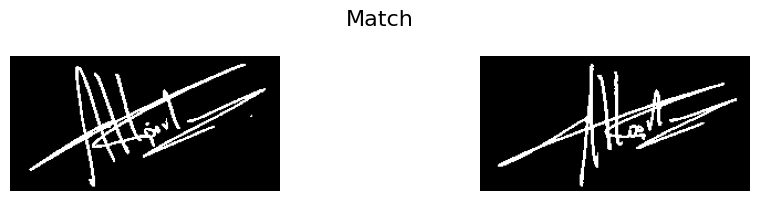

In [46]:
def binarize_image(np_img):
    _, otsu_gauss= cv2.threshold(cv2.GaussianBlur(np_img,(5,5),0),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return otsu_gauss
    
transform = transforms.Compose([
    torchvision.transforms.Lambda(PIL.Image.open),
    torchvision.transforms.Lambda(np.asarray),
    torchvision.transforms.Lambda(binarize_image),
    torchvision.transforms.Lambda(torch.from_numpy),
    torchvision.transforms.Lambda(lambda t : t.unsqueeze(0)),
    torchvision.transforms.Resize((122,244)),
    v2.RGB(),
    v2.ToDtype(torch.float32, scale=True),
    torchvision.transforms.Lambda(lambda v : 1.0-(v > 0.88).float()),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

pds_train = PairDataset(ds_train,x_transform=transform)
pds_valid = PairDataset(ds_valid,x_transform=transform)
x=pds_train[1]
show_pair(x)

In [49]:
dl_train = torch.utils.data.DataLoader(pds_train, batch_size=32, shuffle=True, num_workers=0)
dl_valid = torch.utils.data.DataLoader(pds_valid, batch_size=64, shuffle=True, num_workers=0)

In [6]:
l=next(iter(dataloader))
len(l)

3

In [7]:
l[0].shape

torch.Size([32, 3, 122, 244])

In [98]:
l[1].shape

torch.Size([32, 3, 122, 244])

In [100]:
l[2]

tensor([False,  True, False,  True, False, False, False,  True,  True, False,
        False,  True, False,  True,  True, False,  True, False,  True,  True,
         True,  True, False,  True,  True,  True, False,  True, False, False,
        False, False])

In [51]:
import cv2
x=torchvision.io.read_image(ds[0][0])

x.shape

torch.Size([1, 530, 1713])

In [50]:
class ModifiedResNet18(torch.nn.Module):
    def __init__(self, pretrained=True):
        super(ModifiedResNet18, self).__init__()
        resnet = torchvision.models.resnet18(pretrained=True)
        self.cls = torch.nn.Linear(512,1)
        
        self.features = torch.nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4,
            resnet.avgpool,
            torch.nn.Flatten(),
        )

    def forward(self, x1,x2):
        f1 = self.features(x1)
        f2 = self.features(x2)
        return self.cls(f1-f2)

# Instantiate and test the modified model
model = ModifiedResNet18(pretrained=True)

/opt/anaconda3/envs/ml/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/ml/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [133]:
class ModifiedResNet18(torch.nn.Module):
    def __init__(self, pretrained=True):
        super(ModifiedResNet18, self).__init__()
        resnet = torchvision.models.resnet18(pretrained=True)
        
        self.features = torch.nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4,
            torch.nn.Flatten(),
        )

    def forward(self, x):
        x = self.features(x)
        return x

# Instantiate and test the modified model
model = ModifiedResNet18(pretrained=True)

In [139]:
l[0].shape

torch.Size([32, 3, 122, 244])

In [151]:
r=model(l[0])
r.shape

torch.Size([32, 16384])

In [152]:
def criterion(x1, x2, label, margin: float = 1.0):
    """
    Computes Contrastive Loss
    """

    dist = torch.nn.functional.pairwise_distance(x1, x2)

    loss = (1 - label) * torch.pow(dist, 2) \
        + (label) * torch.pow(torch.clamp(margin - dist, min=0.0), 2)
    loss = torch.mean(loss)

    return loss

In [154]:
import torch.nn as nn
import torch.optim as optim

# Assuming model, siamese_dataloader, device, and num_epochs are predefined
#model = SiameseNetwork().to(device)  # Your Siamese network model
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch in dataloader:
        tensor1, tensor2, labels = batch
        #tensor1, tensor2, labels = tensor1.to(device), tensor2.to(device), labels.to(device, dtype=torch.float32)

        optimizer.zero_grad()

        # Forward pass
        logits1 = model(tensor1)
        logits2 = model(tensor2)  # Assumes model returns logits for the match/mismatch prediction
        labels = labels.view(-1, 1).float()
        loss = criterion(logits1, logits2, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss for reporting
        running_loss += loss.item() * tensor1.size(0)

    # Calculate and print the average loss per epoch
    epoch_loss = running_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/10], Loss: 5963.9701
Epoch [2/10], Loss: 61.1938
Epoch [3/10], Loss: 22.3301
Epoch [4/10], Loss: 12.4925
Epoch [5/10], Loss: 8.2985
Epoch [6/10], Loss: 5.1769
Epoch [7/10], Loss: 4.0320
Epoch [8/10], Loss: 2.8877
Epoch [9/10], Loss: 2.5416
Epoch [10/10], Loss: 2.1810


In [52]:
import torch.nn as nn
import torch.optim as optim

# Assuming model, siamese_dataloader, device, and num_epochs are predefined
#model = SiameseNetwork().to(device)  # Your Siamese network model
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0

    for batch in dl_train:
        tensor1, tensor2, labels = batch
        # tensor1, tensor2, labels = tensor1.to(device), tensor2.to(device), labels.to(device, dtype=torch.float32)

        optimizer.zero_grad()

        # Forward pass
        logits = model(tensor1, tensor2)  # Assumes model returns logits for the match/mismatch prediction
        labels = labels.view(-1, 1).float()
        loss = criterion(logits, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss for reporting
        running_loss += loss.item() * tensor1.size(0)

    # Calculate and print the average loss per epoch
    epoch_loss = running_loss / len(dl_train.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

    # Evaluation Phase
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch in dl_valid:
            tensor1, tensor2, labels = batch
            # tensor1, tensor2, labels = tensor1.to(device), tensor2.to(device), labels.to(device, dtype=torch.float32)

            # Forward pass
            logits = model(tensor1, tensor2)
            labels = labels.view(-1, 1).float()
            loss = criterion(logits, labels)

            # Accumulate validation loss
            val_loss += loss.item() * tensor1.size(0)

            # Calculate accuracy
            predictions = (logits >= 0.5).float()  # Assuming a binary classification with threshold 0.5
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    # Calculate and print the average validation loss and accuracy per epoch
    avg_val_loss = val_loss / len(dl_valid.dataset)
    accuracy = correct_predictions / total_samples * 100
    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%")


Epoch [1/5], Training Loss: 0.7590
Epoch [1/5], Validation Loss: 0.6971, Accuracy: 50.00%


KeyboardInterrupt: 

In [126]:


# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch in dl_train:
        tensor1, tensor2, labels = batch
        #tensor1, tensor2, labels = tensor1.to(device), tensor2.to(device), labels.to(device, dtype=torch.float32)

        optimizer.zero_grad()

        # Forward pass
        logits = model(tensor1, tensor2)  # Assumes model returns logits for the match/mismatch prediction
        labels = labels.view(-1, 1).float()
        loss = criterion(logits, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss for reporting
        running_loss += loss.item() * tensor1.size(0)

    # Calculate and print the average loss per epoch
    epoch_loss = running_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/5], Loss: 0.8701
Epoch [2/5], Loss: 0.7975
Epoch [3/5], Loss: 0.7447
Epoch [4/5], Loss: 0.7483
Epoch [5/5], Loss: 0.7004


In [33]:
class A(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.X = torch.nn.Linear(10,10)
        #self.Y = torch.nn.Sequential(self.X, self.X)

    def forward(self, x):
        x = self.X(x)
        return x
a=A()

In [34]:
list(a.parameters())

[Parameter containing:
 tensor([[-0.0558,  0.2953,  0.1002,  0.2784, -0.0073,  0.2083, -0.2233, -0.0471,
          -0.0122, -0.0924],
         [-0.2368, -0.0949, -0.2500,  0.0622,  0.1938, -0.2045,  0.1575, -0.0427,
           0.0704, -0.0253],
         [-0.1448, -0.1601,  0.0317,  0.0894,  0.2613,  0.1927,  0.2317,  0.0275,
           0.0240,  0.2598],
         [ 0.1159,  0.1685,  0.2193,  0.2538, -0.3033, -0.3081, -0.2351, -0.3030,
           0.0064,  0.1555],
         [-0.3146,  0.0103,  0.3017, -0.1348, -0.2574,  0.2274, -0.0882, -0.1330,
           0.1932,  0.1611],
         [-0.0068,  0.2526,  0.1385, -0.1186, -0.1716, -0.1101, -0.0375, -0.0768,
          -0.2334,  0.0668],
         [ 0.1988,  0.1349, -0.2593, -0.0792,  0.1719, -0.1907, -0.2225, -0.2958,
           0.2216, -0.1340],
         [-0.1870, -0.1073,  0.1612,  0.0643, -0.0088, -0.2451, -0.1487,  0.2127,
           0.1145,  0.1859],
         [-0.3031,  0.3154, -0.2972,  0.0531, -0.0348,  0.0178, -0.2408,  0.1282,
       

In [35]:
a(torch.rand(1,10))

tensor([[ 0.4295, -0.2247,  0.3050, -0.1789, -0.3813, -0.5375, -0.0674, -0.1636,
          0.1320,  0.6198]], grad_fn=<AddmmBackward0>)

In [12]:
import faiss
import numpy as np

# Generate some example data
embeddings = np.random.rand(60000, 128).astype('float32')  # 1000 items, 128-dimensional


In [13]:
embeddings.shape

(60000, 128)

In [14]:
# Initialize the `IndexIVFFlat`
dimension = embeddings.shape[1]
nlist = 200  # number of clusters, set according to dataset size (e.g., sqrt(n) is a common choice)
quantizer = faiss.IndexFlatL2(dimension)  # the base quantizer
index = faiss.IndexIVFFlat(quantizer, dimension, nlist, faiss.METRIC_L2)

In [15]:
# Train the index on a sample of data
index.train(embeddings)  # required before adding vectors to an IVFFlat index
index.add(embeddings)    # add embeddings to the index


In [16]:
# Query the index
query_vector = np.random.rand(128).astype('float32')  # 128-dimensional query vector
k = 5  # number of nearest neighbors
index.nprobe = 10  # number of clusters to search, trade-off between speed and accuracy

# Search for k nearest neighbors
distances, indices = index.search(np.array([query_vector]), k)

# Print results
print("Indices of Neighbors:", indices)
print("Distances to Neighbors:", distances)

Indices of Neighbors: [[ 9808 47029 47531 37302  9020]]
Distances to Neighbors: [[12.514496 14.070881 14.425043 14.658357 14.849606]]
